# Weighting potential calcualtion
heavily inspired by https://github.com/lbl-anp/GammaRayTrackingSchool_2018/

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# general package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress
# from spectrum import gaussian
import pandas as pd

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
# sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab2')
# from tools import find_activity, import_data, subtract_baseline
# from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
# from spectrum import spectrum, gaussian
# from pulse_shape import find_rise_time

In [2]:
# set detector params

# Detector is a 1 x 1 x 1 cm3 CdZnTe crystal from Redlen Technologies 
# Cathode: full area; Anode: 3 x 3 pixel array surrounded by a guard ring; 
# Pixels: 0.75 x 0.75 mm2 on 1 mm pitch 

detector_width = 10.0 # mm
detector_height = 10.0 # mm
pixel_size_mm = 1 # mm

cathode_contact_bias = -1000.0
anode_contact_bias = 0.0

charge_density_zero = -1.0 #TODO - change
charge_density_gradient = 0.1 #TODO - change

In [3]:
# build (uniform) 2D grids for plotting and solving (x=width, y=height (cathode to anode))
x_range = np.arange(0, detector_width, pixel_size_mm)
y_range = np.arange(0, detector_height, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)

# XY mesh for plotting later
X, Y = np.meshgrid(y_range, x_range)

In [4]:
# build a little map of geometry for later, designating pixels based on their nature
# 0 = CZT
# 1 = cathode face
# 2 = anode face
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# outer contact
geom_map[0,:] = 2 # anodes
geom_map[-1,:] = 1 # cathode
geom_map

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [5]:
# set up charge distribution through xtal
charge = np.zeros((N_xelements, N_yelements), dtype=float)
pixels_to_cm = 10/pixel_size_mm

In [6]:
# set boundary conditions and generate initial guess at solution
# 1 = cathode, 0 = core, 2 = anode
V = np.zeros((N_xelements, N_yelements), dtype=float)

# cathode
x,y = np.where(geom_map==1)
V[x,y] = cathode_contact_bias

# anode
x,y = np.where(geom_map==2)
V[x,y] = anode_contact_bias

# passivated back face (not tested)
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0

<IPython.core.display.Javascript object>


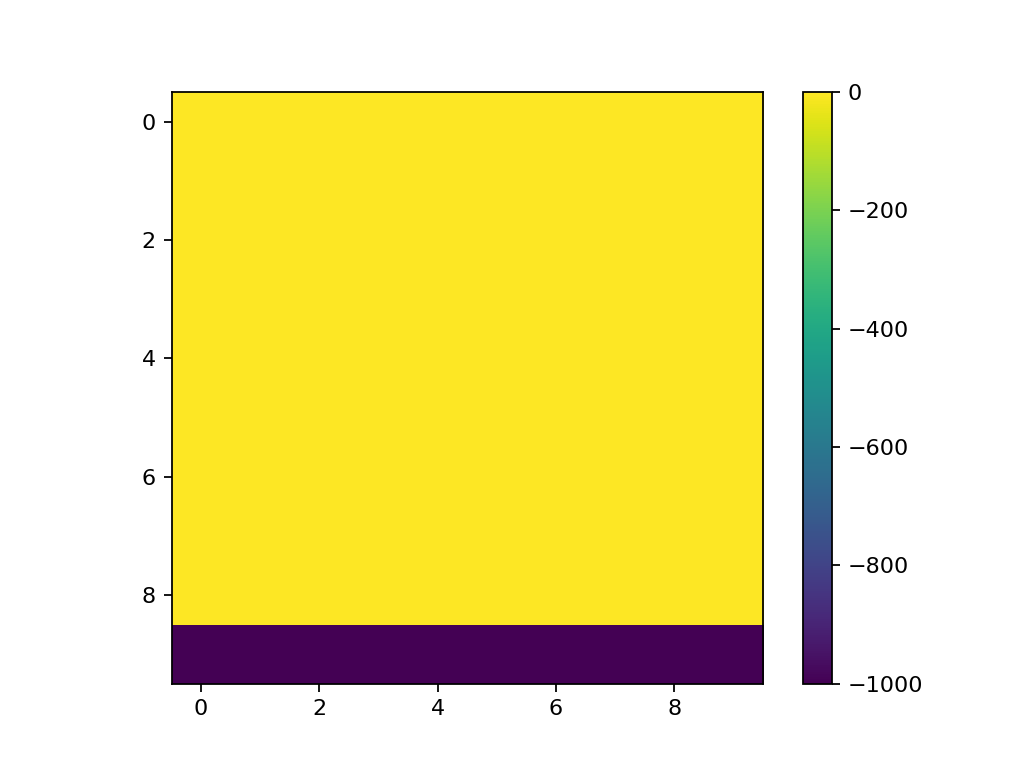

In [7]:
plt.figure()
plt.imshow(V)
plt.colorbar()
plt.show()

In [8]:
# do the relaxation to solve

# set maximum number of iterations
max_iters = 100

# calculate term for Coulombs per pixel / Epsilon
#e_over_e = (pixel_size_mm*pixel_size_mm) * 1e10 * 1.6e-19
e_over_e = (pixel_size_mm*pixel_size_mm/4)* (1e10*1.6e-19)/(16*8.85e-12)

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01
while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(0, N_yelements):
        for x in range(0, N_xelements):
                        
            # skip non-Ge pixels
            if (geom_map[x,y] != 0):
                continue
            
            # handle edges
                                     
#             V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            V_local_sum = (V[x+1,y] + V[x-1,y] )
            
            # update the solution
            R[x,y] = (0.25*V_local_sum + (charge[x,y] * e_over_e)) - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
                 
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

<IPython.core.display.Javascript object>


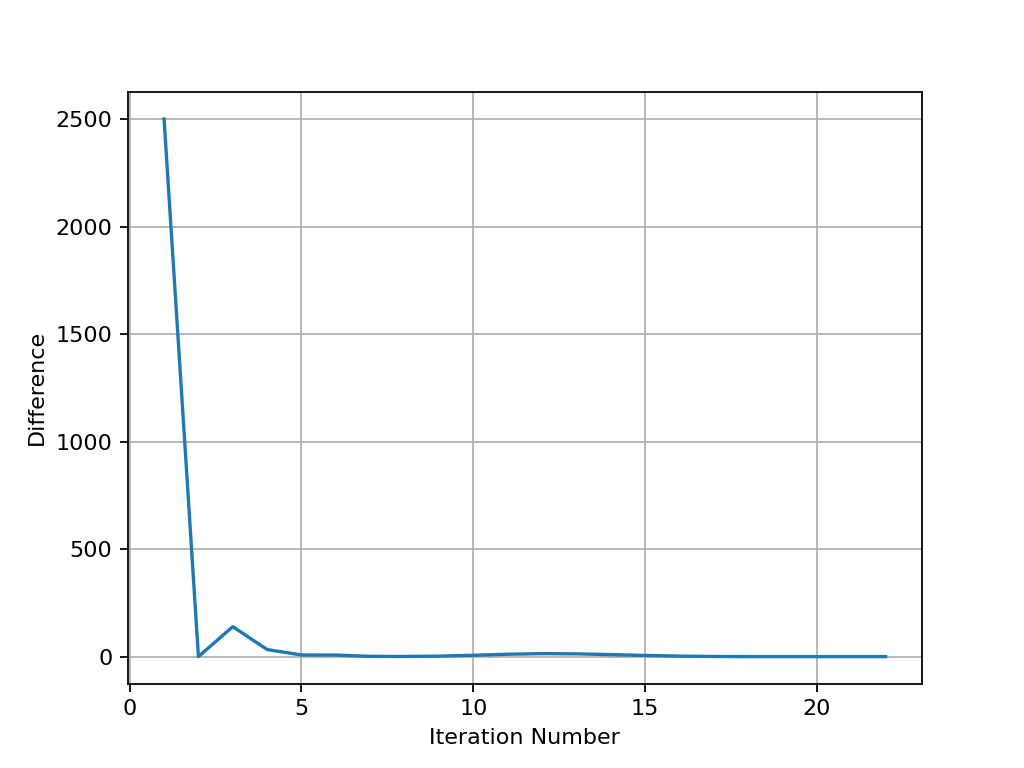

Final Difference:
0.0018566302876621421


In [9]:
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.figure()
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
#plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

<IPython.core.display.Javascript object>


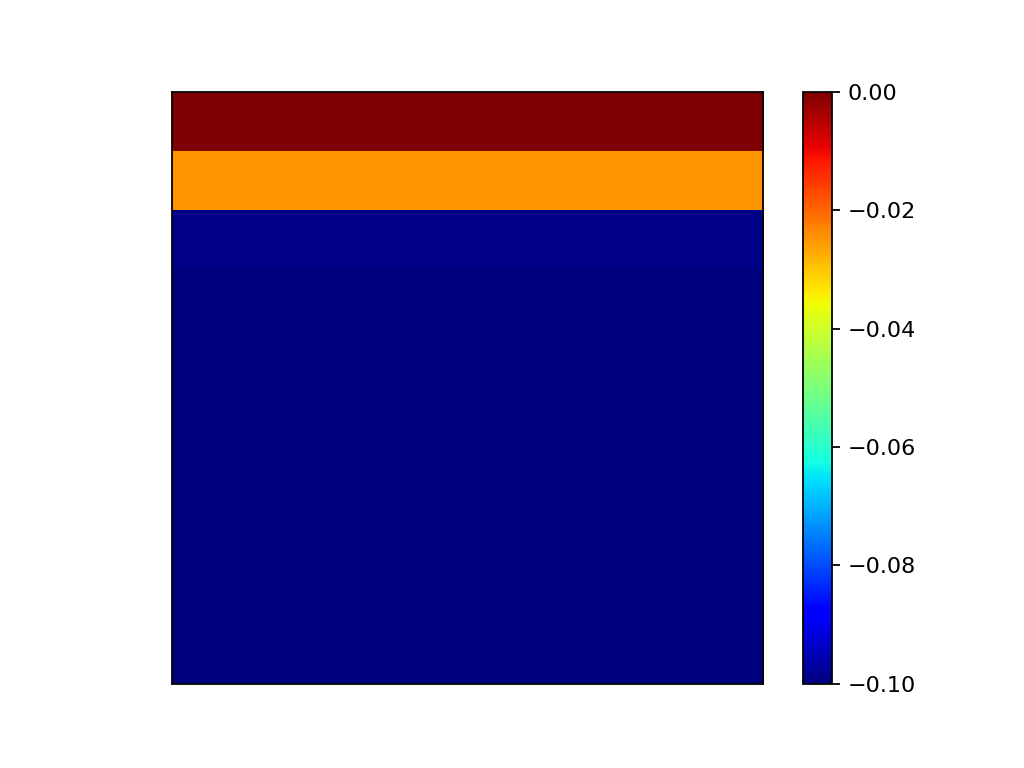

In [10]:
plt.figure()
plt.imshow(V,interpolation="None",cmap='jet',vmin=-0.1)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


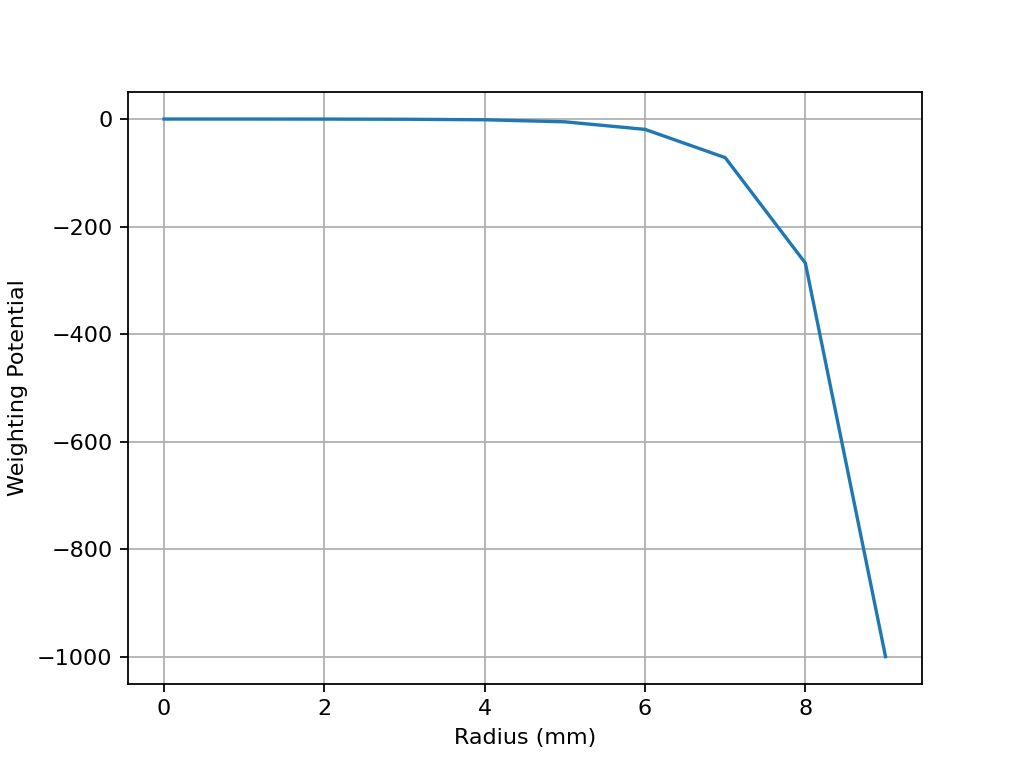

In [13]:
WPslice = V[:,9]
plt.figure()
plt.plot(x_range, WPslice)
plt.grid("on")
plt.xlabel("Radius (mm)")
plt.ylabel("Weighting Potential")
plt.show()

In [15]:
Vslice = WPslice
# simple signal calculation assuming fixed velocity of one pixel per ns for both electrons and holes
# holes into wp, electrons out
# could easily vectorize to be faster and more pythonic

# assume an interaction position at a given depth
depth_mm = 10

z0 = np.int(np.floor(depth_mm / pixel_size_mm))

# number of time steps in signal
Nt = 150

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh = z0
ze = z0

# holes into wp
t = 0
for t in range(1, Nt):
    if (zh<=N_yelements-1):
        dw = Vslice[zh] - Vslice[zh-1]
        Qh[t] = 1.0*dw    
    elif (zh>N_yelements-1):
        continue
    zh = zh+1

# electrons out of wp
t = 0
for t in range(1, Nt):
    if (ze>=0):
        dw = Vslice[ze] - Vslice[ze+1]
        Qe[t] = -1.0*dw
    elif (ze<0):
        continue
    ze = ze-1

# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

# plot
plt.plot(Qsignal_e, 'm', linewidth=1.5)
plt.plot(Qsignal_h, 'c', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)
plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

/var/folders/9q/zxs3bttx79j7gy8t3m35pzm40000gn/T/ipykernel_92859/4176932232.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z0 = np.int(np.floor(depth_mm / pixel_size_mm))


IndexError: index 10 is out of bounds for axis 0 with size 10